# Data Analysis / Preprocessing / Feature Engineering

1. 簡單觀察 Training Data 的各個欄位
2. 對 Training Data 和 Testing Data 做 Preprocessing
3. Feature Engineering, 主要參考 [Kaggle Kernel feature-engineering-xgboost](https://www.kaggle.com/dhimananubhav/feature-engineering-xgboost)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

train = pd.read_csv('dataset/sales_train_v2.csv')
test = pd.read_csv('dataset/test.csv').set_index('ID')
items = pd.read_csv('dataset/items.csv')
cats = pd.read_csv('dataset/item_categories.csv')
shops = pd.read_csv('dataset/shops.csv')

## 1. Data Analysis

### Features

#### Train:

* date: 日期
* date_block_num: 以一個月爲單位 (January 2013 is 0, February 2013 is 1,..., October 2015 is 33)
* shop_id: 商店 id
* item_id: 物品 id
* item_price: 物品當時售價
* item_cnt_day: 物品當天售出量


#### Items:

* item_name: 物品名稱（俄文...) 
* item_id: 物品 id
* item_category_id: 物品分類 id


#### Item_cats:

* item_category_name: 物品分類名稱
* item_category_id: 物品分類 id


#### Shops:

* shop_name: 商店名稱
* shop_id: 商店 id

In [2]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [3]:
train.shape

(2935849, 6)

In [4]:
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [5]:
items.shape

(22170, 3)

In [6]:
cats.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


In [7]:
cats.shape

(84, 2)

In [8]:
shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [9]:
shops.shape

(60, 2)

In [10]:
test.head(1)

,shop_id,item_id
ID,,
0,5,5037


### Monthly Sale

每個月的銷售數量

In [11]:
monthly = pd.DataFrame(train.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index())

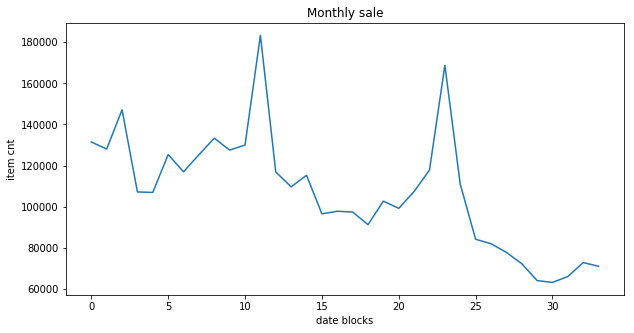

In [12]:
plt.figure(figsize=(10,5))
plt.plot(monthly['date_block_num'], monthly['item_cnt_day'], '-')
plt.xlabel('date blocks')
plt.ylabel('item cnt')
plt.title('Monthly sale')
plt.show()

## 2. Preprocessing

### Outliers

把所有 item 做排序後發現有異常值（1000、2169），當成 Outlier 去除

In [13]:
sorted(train['item_cnt_day'])[-10:]

[504.0, 508.0, 512.0, 533.0, 539.0, 624.0, 637.0, 669.0, 1000.0, 2169.0]

In [14]:
train = train[train['item_cnt_day'] < 1000]

### Some shops are duplicate

參考[Kaggle Kernal-feature-engineering-xgboost](https://www.kaggle.com/dhimananubhav/feature-engineering-xgboost)，在 Data 中有一些商店名字是重復的（根據俄文的含義），將重復的名字換成同一個

In [15]:
a = shops[shops['shop_id'] == 0].iloc[0]['shop_name']
b = shops[shops['shop_id'] == 57].iloc[0]['shop_name']

print('Shop names:\n{}\n{}\nare the same'.format(a, b))

train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

Shop names:
!Якутск Орджоникидзе, 56 фран
Якутск Орджоникидзе, 56
are the same


In [16]:
a = shops[shops['shop_id'] == 1].iloc[0]['shop_name']
b = shops[shops['shop_id'] == 58].iloc[0]['shop_name']

print('Shop names:\n{}\n{}\nare the same'.format(a, b))

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

Shop names:
!Якутск ТЦ "Центральный" фран
Якутск ТЦ "Центральный"
are the same


In [17]:
a = shops[shops['shop_id'] == 10].iloc[0]['shop_name']
b = shops[shops['shop_id'] == 11].iloc[0]['shop_name']

print('Shop names:\n{}\n{}\nare the same'.format(a, b))

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

Shop names:
Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²
are the same


### Shops/Cats/Items preprocessing

經過觀察，每個 shop 都是由 城市名 + 商店名 組成
每個 category 是由 type + subtype 組成

運用 LabelEncoder 將 城市名 和 type 做 Encoding

In [18]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [19]:
cats.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [20]:
from sklearn.preprocessing import LabelEncoder

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [21]:
shops.head(2)

,shop_id,city_code
0,0,29
1,1,29


In [22]:
cats.head(2)

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9


### Test set 中有一些 item 不屬於 Train set

363 Items not in train set

In [23]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id))))

363

### Create Combinations

使用 itertools 的 product 產生由 date_block_num , shop_id, item_id 所產生的所有組合

In [24]:
from itertools import product

matrix = []

for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [25]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

### Merge with the original train set

把產生出的所有的組合和原本的 Training set 進行 left merge

因爲 product 後的所有組合量很大，會有很多的 NAN，對這些 nan 使用 fillna（0）

In [26]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

cols = ['date_block_num','shop_id','item_id']
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

整合過後的 Training Dataset

date_block_num 爲 0~33

總共有 10913850 個 Entry

In [27]:
matrix.describe()

,date_block_num,shop_id,item_id,item_cnt_month
count,1.091385e+07,1.091385e+07,1.091385e+07,10913850.0
mean,1.497334e+01,3.137817e+01,1.130926e+04,NaN
std,9.495618e+00,1.730214e+01,6.209978e+03,0.0
min,0.000000e+00,2.000000e+00,0.000000e+00,0.0
25%,7.000000e+00,1.600000e+01,5.976000e+03,0.0
50%,1.400000e+01,3.000000e+01,1.139100e+04,0.0
75%,2.300000e+01,4.700000e+01,1.660500e+04,0.0
max,3.300000e+01,5.900000e+01,2.216900e+04,20.0


### Append Test Set

將 Test set 合並到整個 matrix 中

爲了縮小 data size：

* date_block_num 轉型爲 int8
* shop_id 轉型爲 int8
* item_id 轉型爲 int16

In [28]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

直接把 test data 合並在 train data 的尾端，以利之後的 lag feature 操作

In [29]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

In [30]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

## 3. Feature Engineering

### Generate lag feature

產生 lag feature（ n 個 date_block_num 之前的資料）

In [31]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

產生對於 item_cnt_month 的 lag features

In [32]:
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

### Mean Coded Features

計算根據不同 group 條件下，每一組 group 結果中銷售數量（item_cnt_month) 的平均值

1. 根據每個月進行 group（date_block_num)，算出平均 item_cnt_month

In [33]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

2. 根據 date_block_num 和 item_id 進行 group，算出平均 item_cnt_month, 並且計算 1, 2, 3, 6, 12 個月的 lag feature

In [34]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

3. 根據 date_block_num 和 shop_id 進行 group，算出平均 item_cnt_month, 並且計算 1, 2, 3, 6, 12 個月的 lag feature

In [35]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

4. 根據 date_block_num 和 item_category_id 進行 group，算出平均 item_cnt_month

In [36]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

5. 根據 date_block_num, shop_id 和 item_category_id 進行 group，算出平均 item_cnt_month

In [37]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

6. 根據 date_block_num, shop_id 和 type_code 進行 group，算出平均 item_cnt_month

In [38]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

7. 根據 date_block_num, shop_id 和 subtype_code 進行 group，算出平均 item_cnt_month

In [39]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

8. 根據 date_block_num 和 city_code 進行 group，算出平均 item_cnt_month

In [40]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

9. 根據 date_block_num, item_id 和 city_code 進行 group，算出平均 item_cnt_month

In [41]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

10. 根據 date_block_num 和 type_code 進行 group，算出平均 item_cnt_month

In [42]:
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

11. 根據 date_block_num 和 subtype_code 進行 group，算出平均 item_cnt_month

In [43]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

### Trend features

計算 6 個月物品價錢的趨勢

In [44]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)


### Revenue

計算每個月的 revenue 和上一個月 revenue 的比值

In [45]:
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

### Month feature

把 date_block_num 對 12 取餘數後得到月份

In [46]:
matrix['month'] = matrix['date_block_num'] % 12

### Day feature

填入每個月有幾天（天數可能影響銷量）

In [47]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

### Month since last sale

計算一組（商店+物品）最後一次售出和上一次售出差幾個月

In [48]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

計算一個物品最後一次售出和上一次售出差幾個月

In [49]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

In [50]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

### Drop some data

因爲之前有用到 12 個月的 lag feature，所以 drop 掉前 12 個月的所有 data

In [51]:
matrix = matrix[matrix.date_block_num > 11]

### Fill all null values

In [52]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

### Export engineered features 

In [53]:
import pickle

import gc


matrix.to_pickle('data.pkl')

del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();